In [22]:
import warnings 
warnings.filterwarnings('ignore')
import time 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy import stats
from scipy.stats import norm

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
data      = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/ubaar-competition/train.csv')
test_data = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/ubaar-competition/test.csv')

# Remove NANs
data      = data.dropna(axis = 0)

# Remove outliers
data.drop([28098])
THRESHOLD = 4.5e7
Aa = data[data.price > THRESHOLD]
data = data.drop(Aa.index.tolist())

specific_cols = ['distanceKM', 'taxiDurationMin', 'weight']
removed_indices = []
for col in specific_cols:
    df = data['price']/data[col]
    A = df[~df.isin([np.nan, np.inf, -np.inf])]
    B = (A - np.mean(A)) / np.std(A)
    V = B[B > 5]
    removed_indices.extend(V.index.tolist())
data = data.drop(set(removed_indices))

# Fill test NANs
test_data.loc[12577, 'distanceKM']      = 52
test_data.loc[12577, 'taxiDurationMin'] = 50
test_data.loc[13853, 'distanceKM']      = 500
test_data.loc[13853, 'taxiDurationMin'] = 380

all_data = pd.concat((data, test_data)) 
all_data['source']           = all_data['sourceLatitude']*all_data['sourceLongitude']
all_data['destination']      = all_data['destinationLatitude']*all_data['destinationLongitude']

ntrain = data.shape[0]
ntest  = test_data.shape[0]

categorical_vars = ['date', 'SourceState', 'destinationState', 'vehicleType', 'vehicleOption']

dummies_data = pd.get_dummies(all_data[categorical_vars])
all_data[dummies_data.columns] = dummies_data[dummies_data.columns]
all_data.drop(categorical_vars, axis=1, inplace=True)

train    = all_data[:ntrain]
test     = all_data[ntrain:]

feat_names = all_data.columns.tolist()
feat_names.remove('ID')
feat_names.remove('price')

X = train.drop(['ID','price'],axis=1)
y = train.price

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(39645, 84)

# Plots 

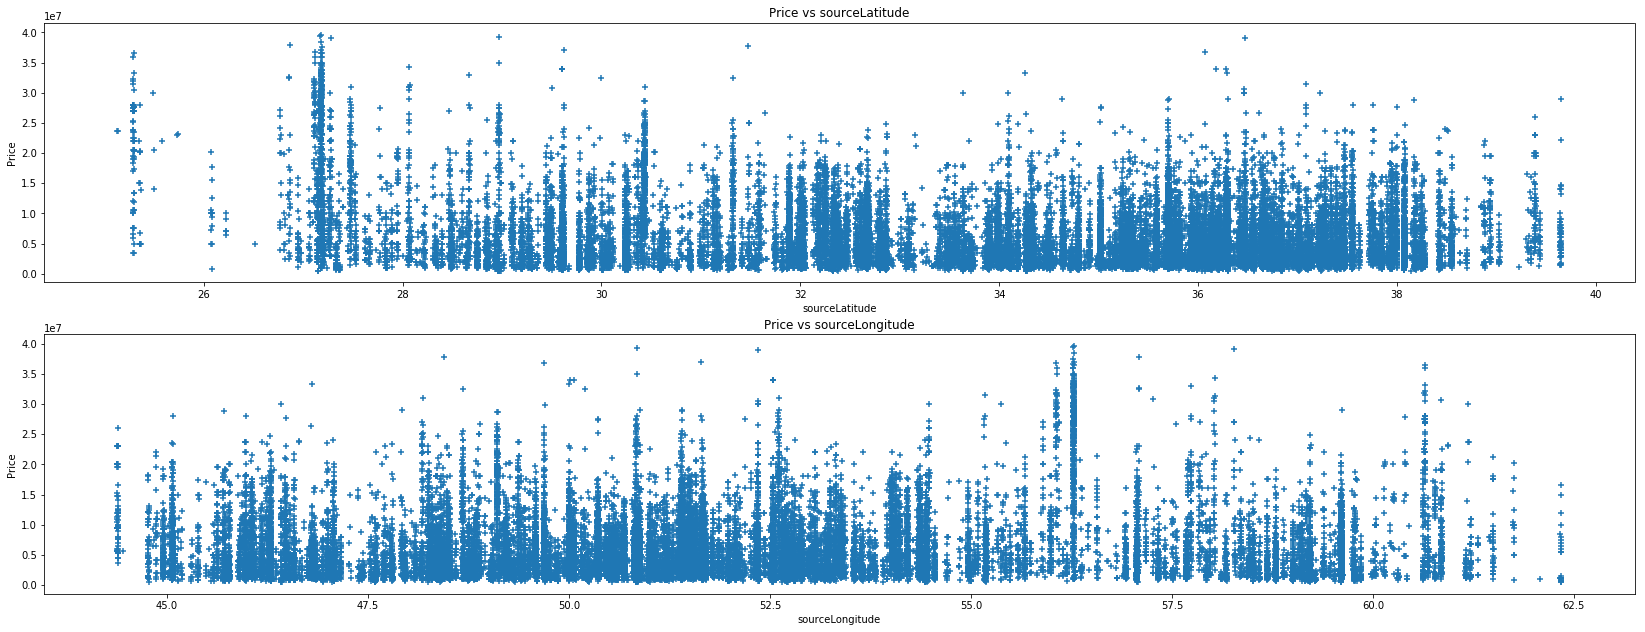

In [3]:
fig1, (ay1, ay2) = plt.subplots(2, 1)


ay1.scatter(x = X_train['sourceLatitude'], y = y_train, marker = "+")
ay1.set_title('Price vs sourceLatitude')
ay1.set_xlabel('sourceLatitude')
ay1.set_ylabel('Price')

ay2.scatter(x = X_train['sourceLongitude'], y = y_train, marker = "+")
ay2.set_title('Price vs sourceLongitude')
ay2.set_xlabel('sourceLongitude')
ay2.set_ylabel('Price')

fig1.set_size_inches(28.5, 10.5)
fig1.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/sourceEffects.png", dpi=100)
plt.show()

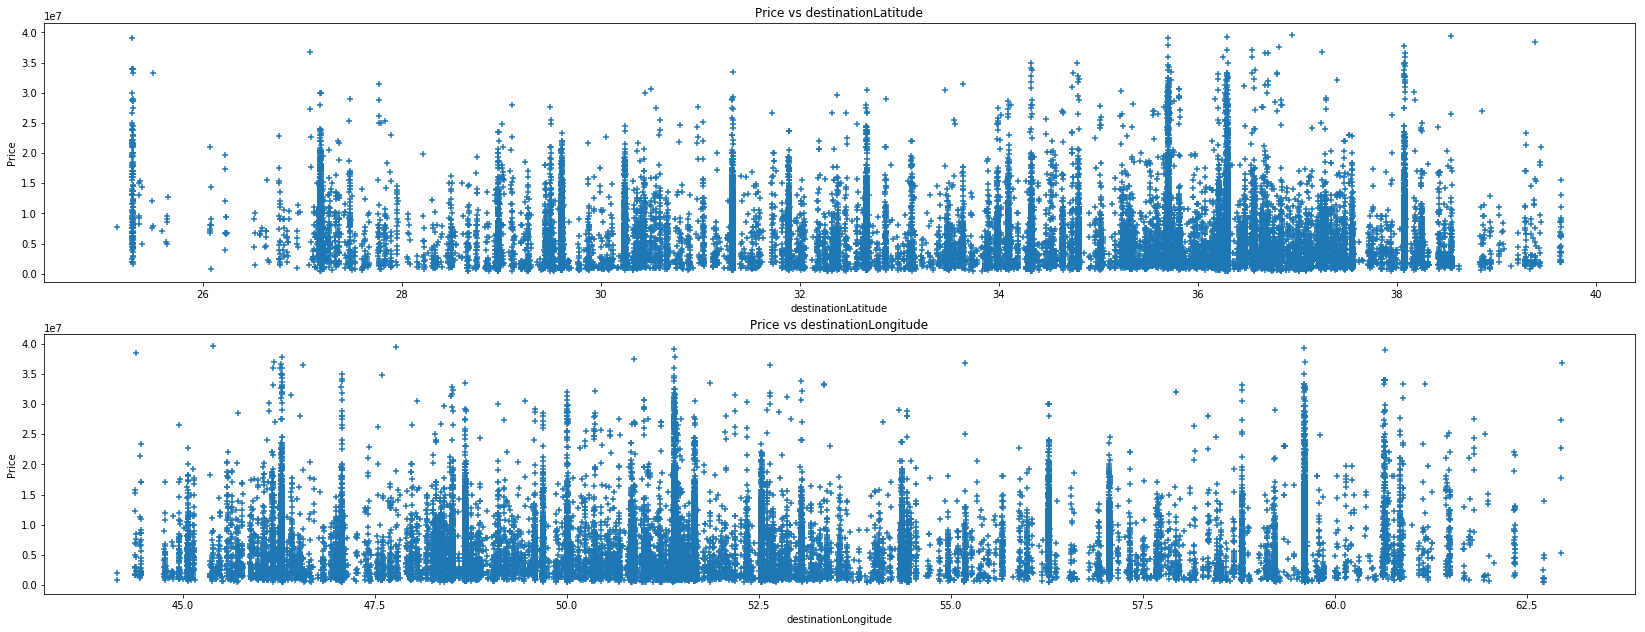

In [4]:
fig2, (ay3, ay4) = plt.subplots(2, 1)


ay3.scatter(x = X_train['destinationLatitude'], y = y_train, marker = "+")
ay3.set_title('Price vs destinationLatitude')
ay3.set_xlabel('destinationLatitude')
ay3.set_ylabel('Price')

ay4.scatter(x = X_train['destinationLongitude'], y = y_train, marker = "+")
ay4.set_title('Price vs destinationLongitude')
ay4.set_xlabel('destinationLongitude')
ay4.set_ylabel('Price')

fig2.set_size_inches(28.5, 10.5)
fig2.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/destinationEffects.png", dpi=100)
plt.show()

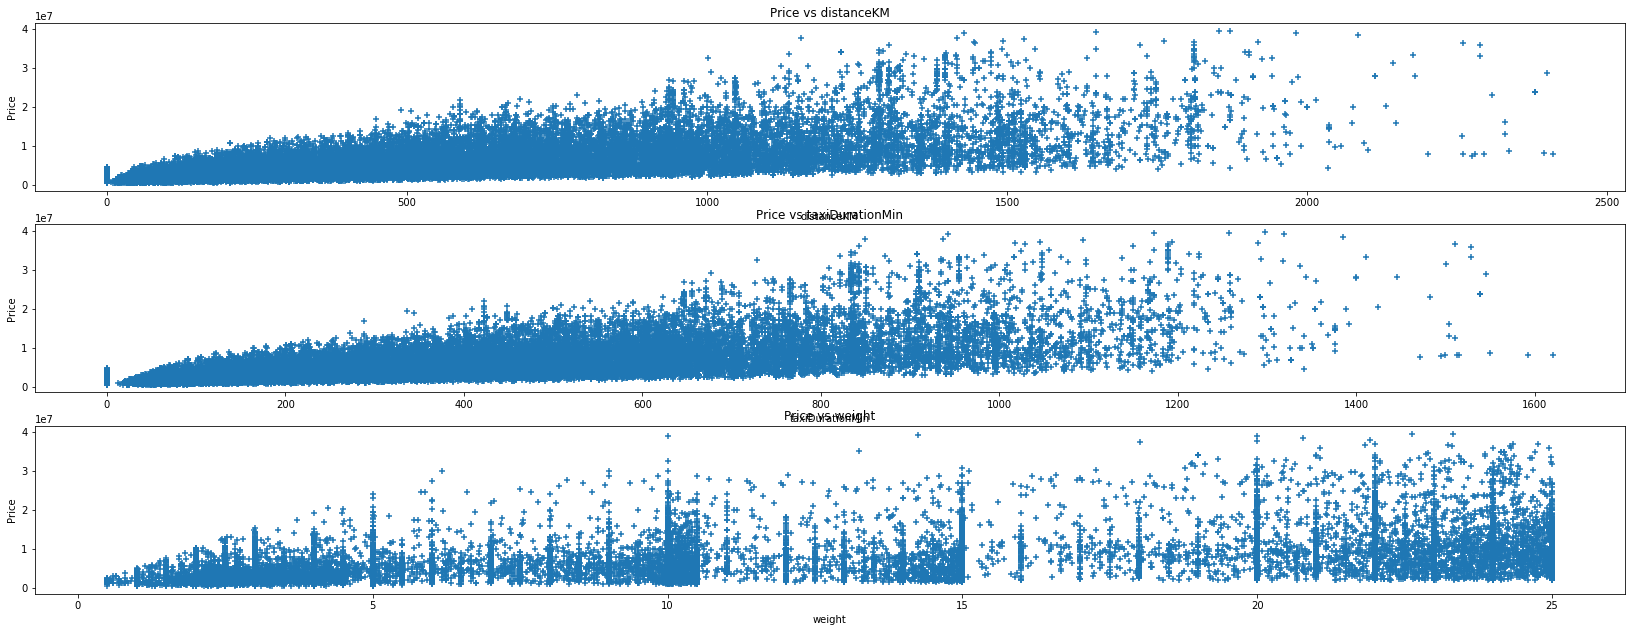

In [5]:
fig3, (ay3, ay4, ay5) = plt.subplots(3, 1)


ay3.scatter(x = X_train['distanceKM'], y = y_train, marker = "+")
ay3.set_title('Price vs distanceKM')
ay3.set_xlabel('distanceKM')
ay3.set_ylabel('Price')

ay4.scatter(x = X_train['taxiDurationMin'], y = y_train, marker = "+")
ay4.set_title('Price vs taxiDurationMin')
ay4.set_xlabel('taxiDurationMin')
ay4.set_ylabel('Price')

ay5.scatter(x = X_train['weight'], y = y_train, marker = "+")
ay5.set_title('Price vs weight')
ay5.set_xlabel('weight')
ay5.set_ylabel('Price')

fig3.set_size_inches(28.5, 10.5)
fig3.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/distance-time-Effects.png", dpi=100)
plt.show()

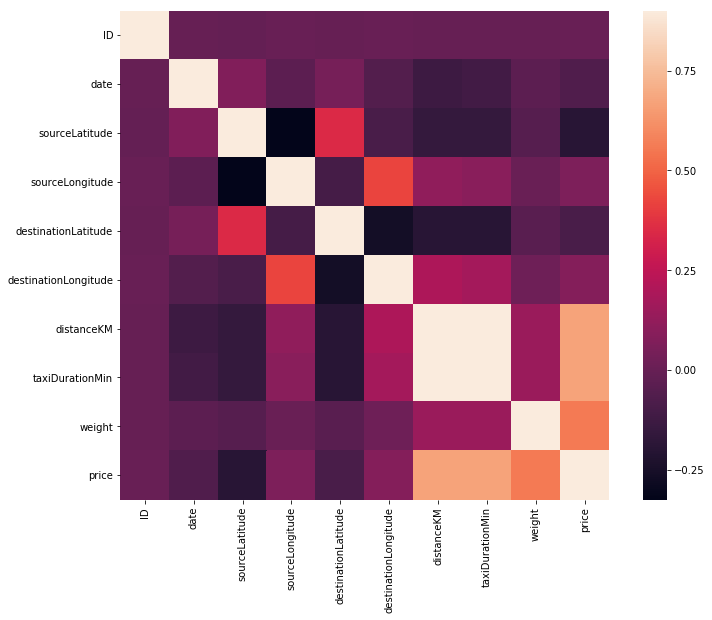

In [6]:
corrmat = data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)


 mu = 5701378.84 and sigma = 4716477.44



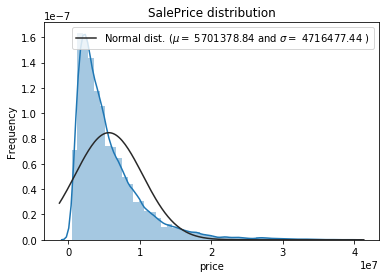

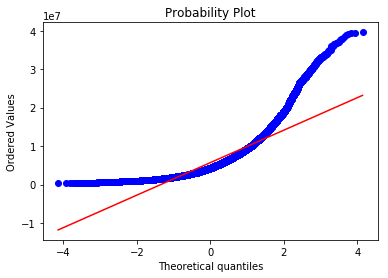

In [9]:
sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)

print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()


 mu = 15.27 and sigma = 0.76



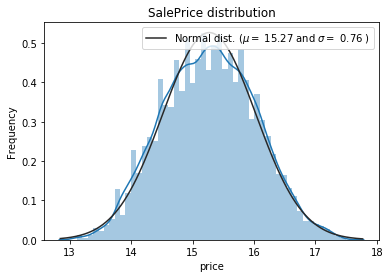

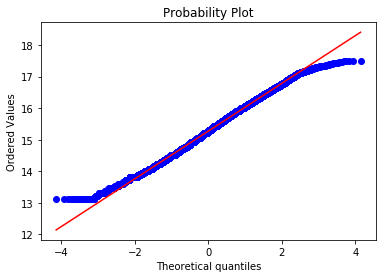

In [10]:
y_train_lp = np.log1p(y_train)

sns.distplot(y_train_lp, fit=norm);
(mu, sigma) = norm.fit(y_train_lp)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train_lp, plot=plt)
plt.show()

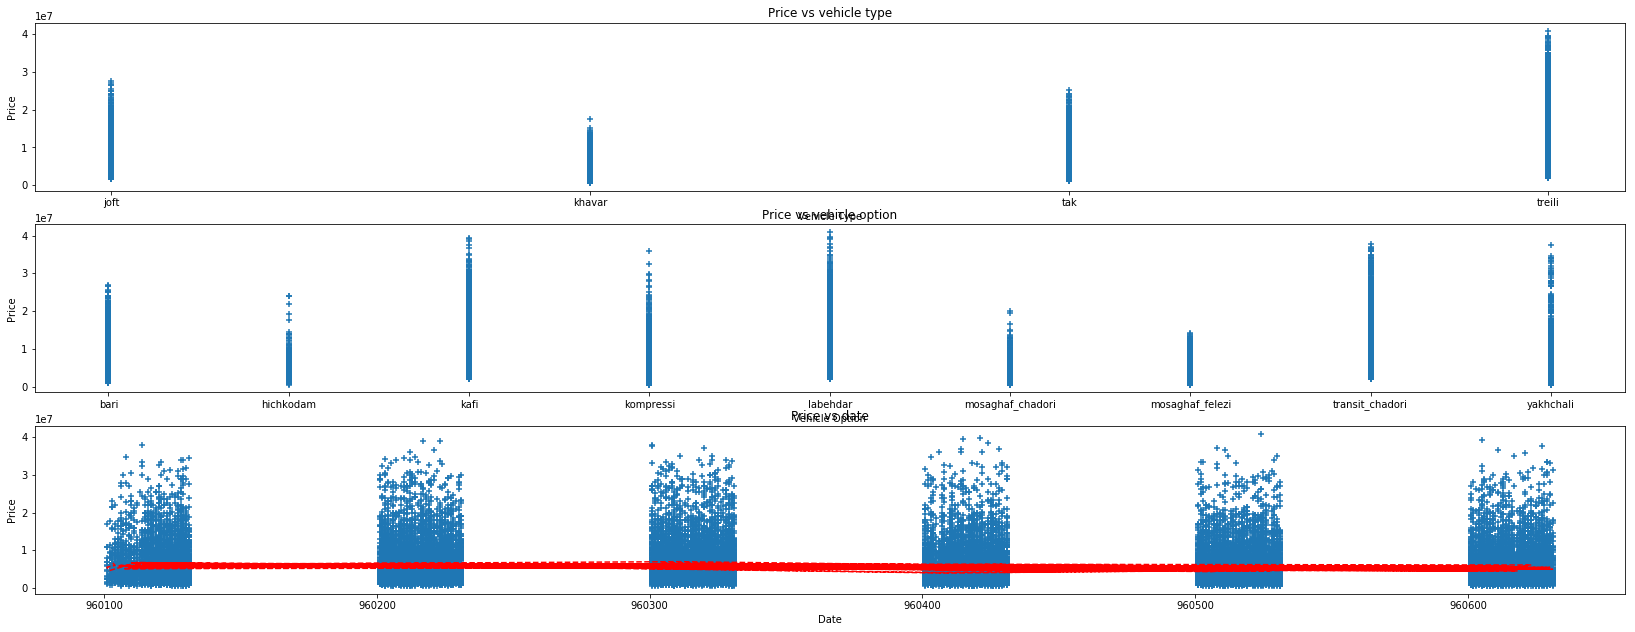

In [13]:
fig1, (ay1, ay2, ay3) = plt.subplots(3, 1)


ay1.scatter(data.vehicleType, data.price, marker = "+")
ay1.plot([0, 1, 2, 3], [np.mean(data.query('vehicleType == 0').price), np.mean(data.query('vehicleType == 1').price),
         np.mean(data.query('vehicleType == 2').price), np.mean(data.query('vehicleType == 3').price)], 'r--')

ay1.set_title('Price vs vehicle type')
ay1.set_xlabel('Vehicle Type')
ay1.set_ylabel('Price')


ay2.scatter(data.vehicleOption, data.price, marker = "+")
ay2.plot([0, 1, 2, 3, 4, 5, 6, 7, 8], [np.mean(data.query('vehicleOption == 0').price), 
                                       np.mean(data.query('vehicleOption == 1').price),
                                       np.mean(data.query('vehicleOption == 2').price), 
                                       np.mean(data.query('vehicleOption == 3').price), 
                                       np.mean(data.query('vehicleOption == 4').price), 
                                       np.mean(data.query('vehicleOption == 5').price),
                                       np.mean(data.query('vehicleOption == 6').price),
                                       np.mean(data.query('vehicleOption == 7').price), 
                                       np.mean(data.query('vehicleOption == 8').price)], 'r--')


ay2.set_title('Price vs vehicle option')
ay2.set_xlabel('Vehicle Option')
ay2.set_ylabel('Price')

ay3.scatter(data.date, data.price, marker = "+")
ay3.plot(all_dates, date_price_vec, 'r--')
ay3.set_title('Price vs date')
ay3.set_xlabel('Date')
ay3.set_ylabel('Price')


fig1.set_size_inches(28.5, 10.5)
fig1.savefig("/Users/mohsenkiskani/Downloads/Ubaar/plots/categoryEffects.png", dpi=100)
plt.show()

# Which features are most important?

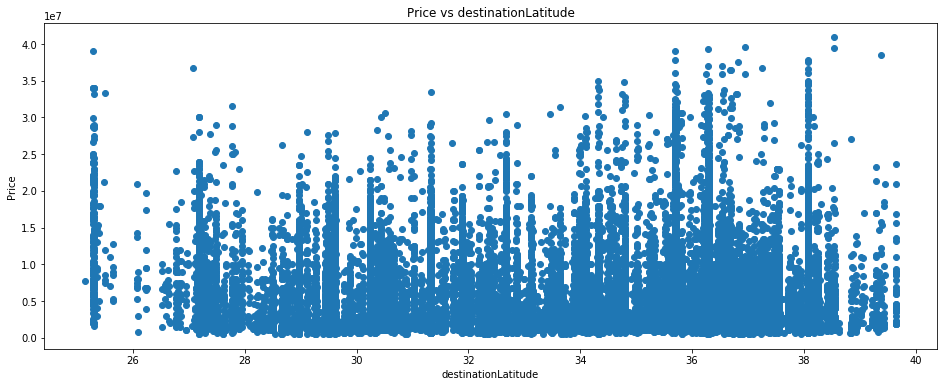

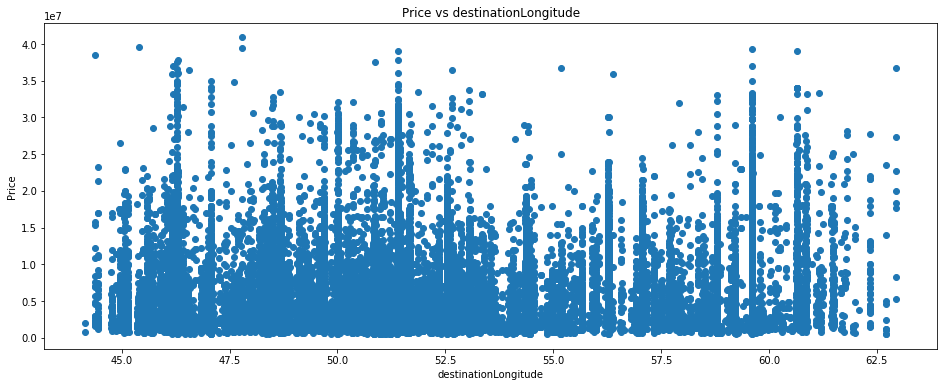

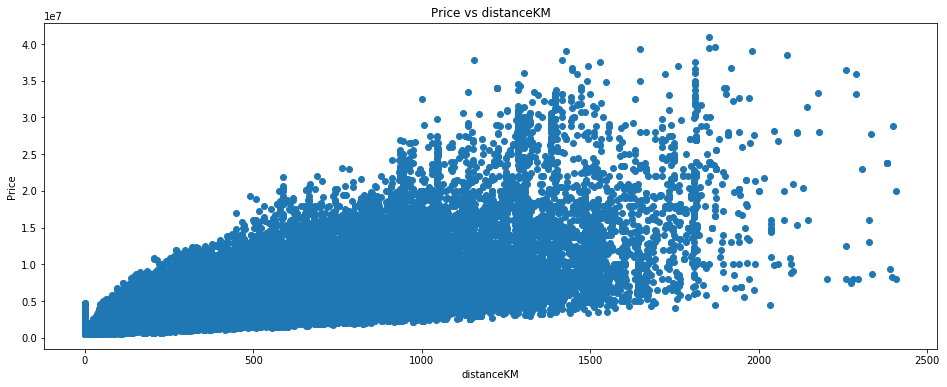

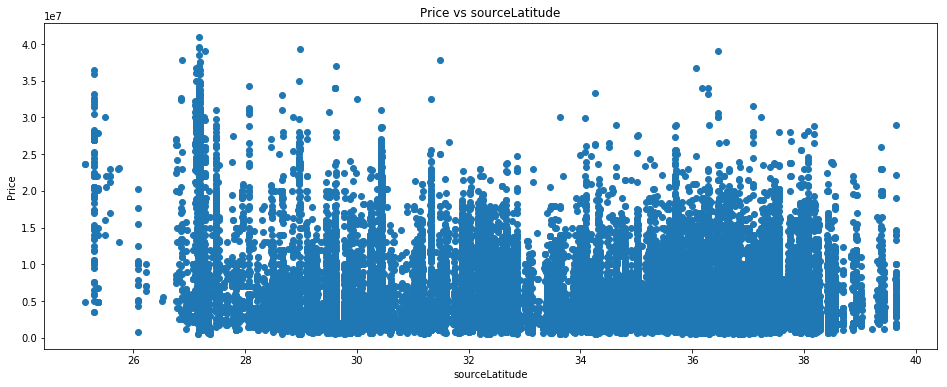

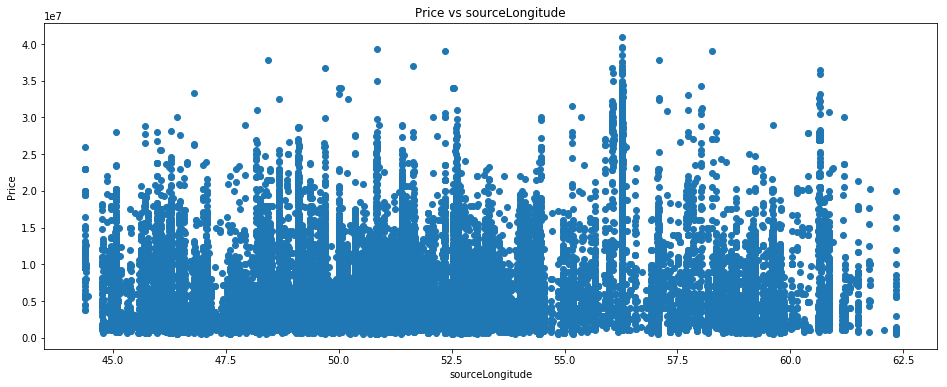

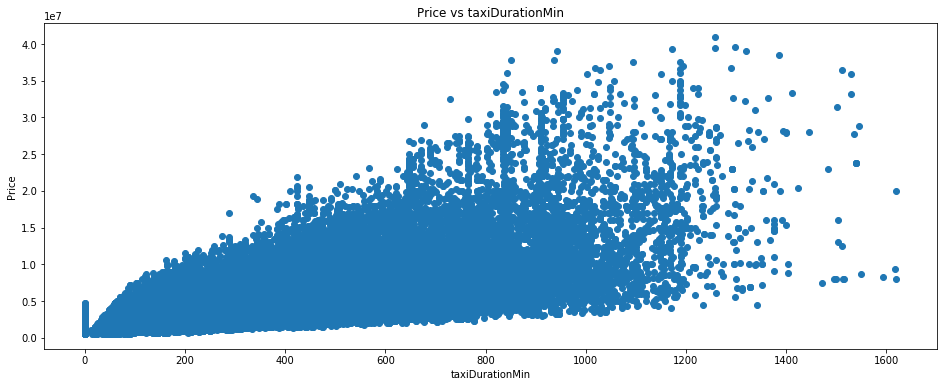

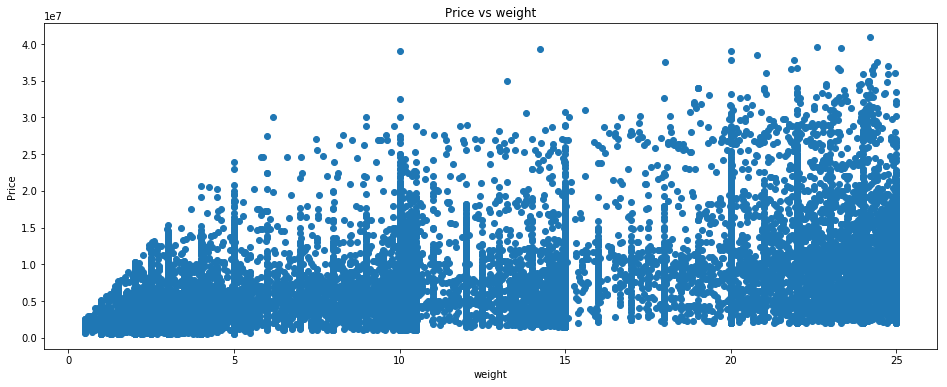

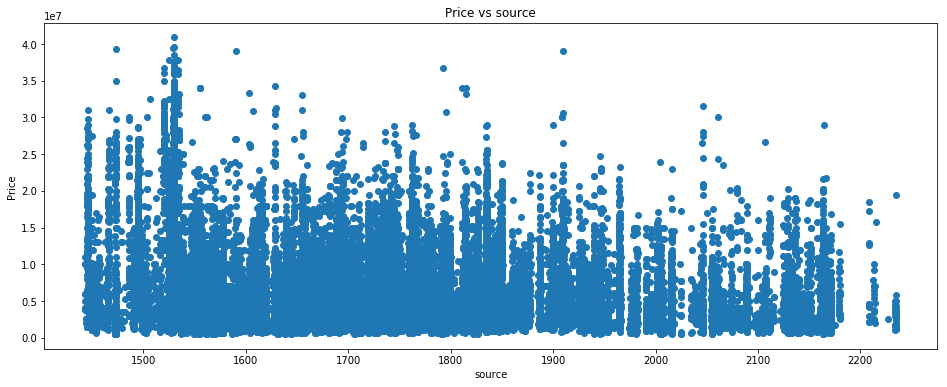

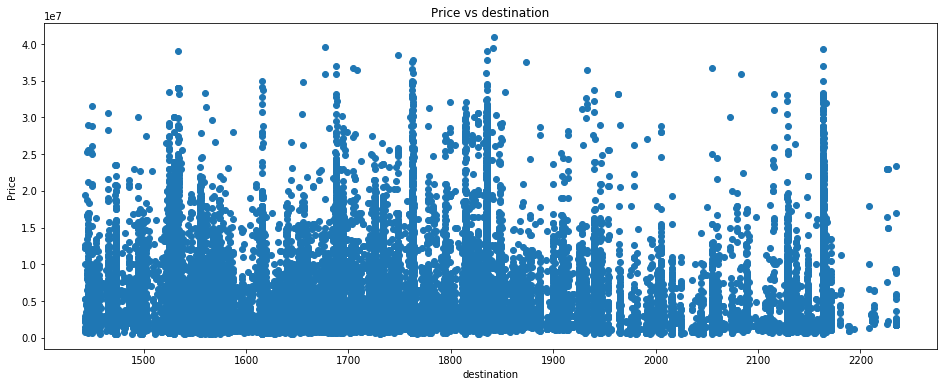

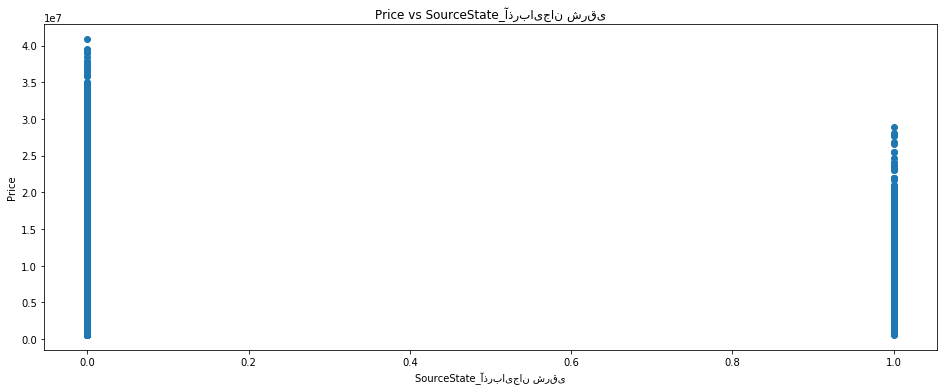

In [15]:
for col in X_train.columns[:10]:
    plt.figure(figsize=(16,6))
    plt.scatter(train[col], train['price'])
    plt.title('Price vs '+ col)
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

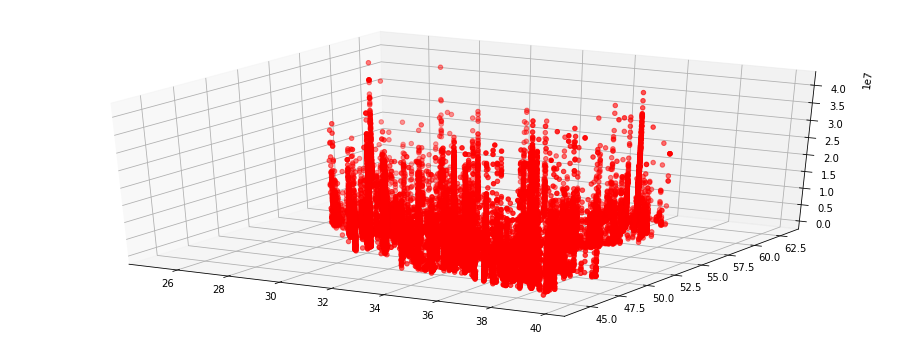

In [16]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['destinationLatitude'], train['destinationLongitude'], train['price'], c='r', marker='o')

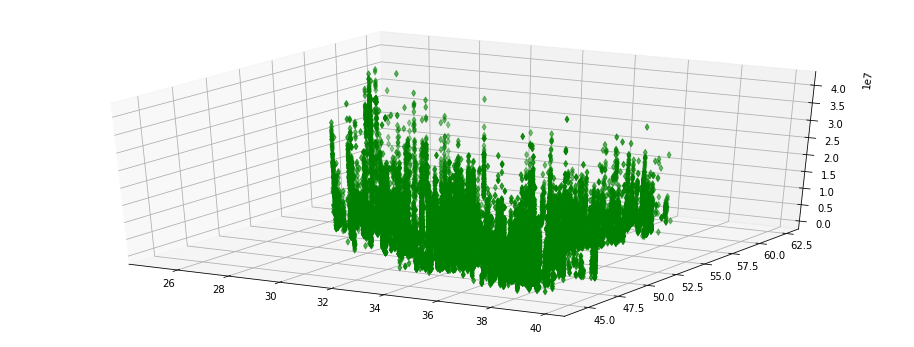

In [17]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['sourceLatitude'], train['sourceLongitude'], train['price'], c='g', marker='d')

# Feature distributions

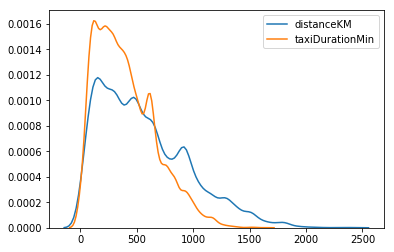

In [18]:
sns.kdeplot(train['distanceKM'])
sns.kdeplot(train['taxiDurationMin'])

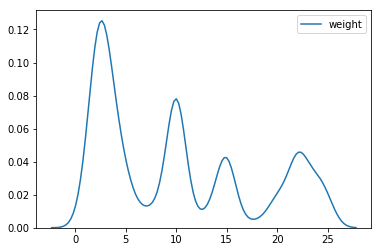

In [19]:
sns.kdeplot(train['weight'])

# Which features are the most important in each model?

In [23]:
XGBF = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                        learning_rate=0.05, max_depth=10, 
                        min_child_weight=1.7817, n_estimators=200,
                        reg_alpha=0.4640, reg_lambda=0.8571,
                        subsample=0.5213, silent=1, seed = 10,
                        random_state =5 , nthread = -1)

Text(0,0.5,'Feature Importance Score')

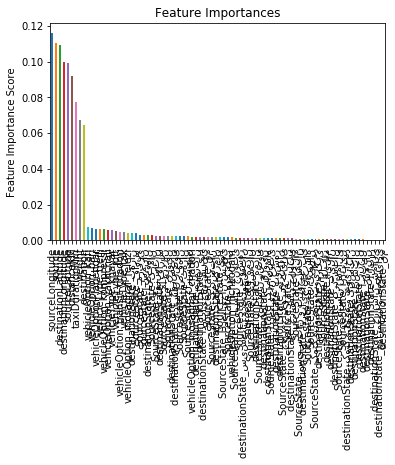

In [24]:
XGBF.fit(X_train, y_train)

feature_importances = pd.Series(XGBF.feature_importances_, X_train.columns.values)
feature_importances = feature_importances.sort_values(ascending=False)

feature_importances.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [25]:
LGBF = lgb.LGBMRegressor(objective='regression',num_leaves=15,
                          learning_rate=0.05, n_estimators=150,
                          max_bin = 1000, bagging_fraction = 0.6,
                          bagging_freq = 5, feature_fraction = 0.25,
                          feature_fraction_seed=9, bagging_seed=20,
                          min_data_in_leaf = 11, min_sum_hessian_in_leaf = 11)

Text(0,0.5,'Feature Importance Score')

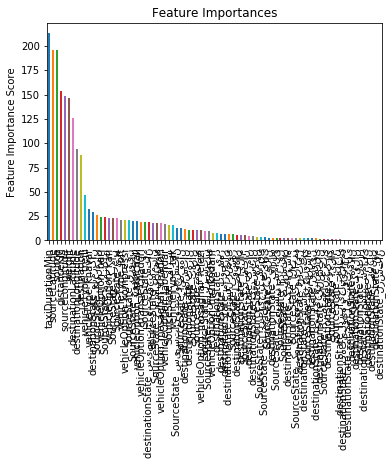

In [26]:
LGBF.fit(X_train, y_train)

feature_importances = pd.Series(LGBF.feature_importances_, X_train.columns.values)
feature_importances = feature_importances.sort_values(ascending=False)

feature_importances.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [27]:
GBSTF = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,
                                  max_depth=10, max_features='sqrt',
                                  min_samples_leaf=15, min_samples_split=10, 
                                  loss='huber', random_state =5)

Text(0,0.5,'Feature Importance Score')

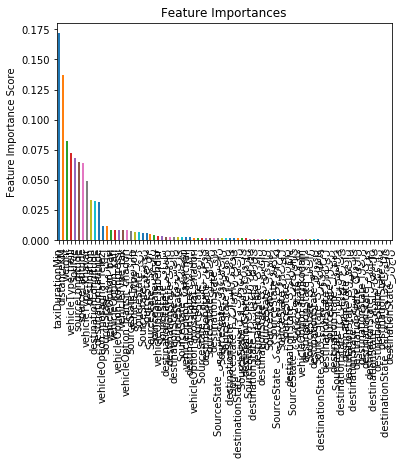

In [28]:
GBSTF.fit(X_train, y_train)

feature_importances = pd.Series(GBSTF.feature_importances_, X_train.columns.values)
feature_importances = feature_importances.sort_values(ascending=False)

feature_importances.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')